In [1]:
import sys
sys.path.append('a/UltimeTradingBot/Crypto_backtest_tools')
from utilities.get_data import get_historical_from_db
from utilities.backtesting import basic_single_asset_backtest, plot_wallet_vs_asset, get_metrics
import pandas as pd
import ccxt
import matplotlib.pyplot as plt
import ta
import json
import numpy as np
import random
from sklearn.utils import shuffle
import seaborn as sns
from utilities.backtesting import plot_wallet_vs_asset, get_metrics, get_n_columns, basic_multi_asset_backtest, plot_sharpe_evolution, plot_bar_by_month
from utilities.custom_indicators import SuperTrend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
import os
pd.options.mode.chained_assignment = None  # default='warn'


In [2]:

import tensorflow as tf
#tf.test.is_gpu_available(
#     cuda_only=False, min_cuda_compute_capability=None
# )
tf.config.list_physical_devices('GPU')

!nvidia-smi



Mon Sep 19 12:03:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.77       Driver Version: 512.77       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P8    N/A /  N/A |   3110MiB /  4096MiB |     19%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [29]:
import warnings
warnings.filterwarnings('ignore')
PRERR=False
def prerr(err):
    if PRERR:
        print("\033[0;31m Error in "+str(sys._getframe().f_code.co_name) +" \033[0;33m"+str(err))

In [4]:
#MetaData=get_crypto_metadata(Binance_USDT_HALAL)
MetaData = pd.read_csv("D:\+DATA+\MetaData.csv")
df = pd.read_csv('D:/+DATA+/allok_w15_nosell.csv',index_col=0)

In [5]:
#df=df.drop(columns="sell")
#df=df.drop(columns=["Unnamed: 0"])
#df.to_csv('D:/+DATA+/allok_w15_nosell.csv')

In [6]:
sys.getsizeof(df)/(1024**2)

6337.254440307617

## Testing impoted DATA

In [7]:
df[df['buy']==1]

,open,high,low,close,volume,high-1,low-1,open-1,close-1,volume-1,...,BTC_high-15_5min,BTC_low-15_5min,BTC_open-15_5min,BTC_close-15_5min,BTC_volume-15_5min,day,hour,minute,lunch_day,buy
5,0.259200,0.259300,0.254700,0.258000,38103.38,0.259900,0.257900,0.259000,0.259400,26573.45,...,52500.42,52066.99,52066.99,52469.49,909.313696,1,15,18,-117,1
6,0.000043,0.000043,0.000043,0.000043,47526628.00,0.000043,0.000043,0.000043,0.000043,21892392.00,...,29609.47,29536.22,29536.23,29564.50,272.084180,6,4,37,-611,1
7,0.052220,0.052220,0.052220,0.052220,218.60,0.052250,0.052240,0.052250,0.052240,814.50,...,19085.65,19052.62,19085.64,19076.30,120.363966,1,3,18,-314,1
11,3.036200,3.036200,3.008200,3.018100,101695.10,3.046600,3.035300,3.046500,3.035700,6457.70,...,39785.99,39713.50,39719.99,39767.99,125.824500,4,13,59,-741,1
17,0.287290,0.287900,0.286660,0.287710,45267.50,0.287900,0.286760,0.287350,0.287290,64389.70,...,35949.60,35861.24,35870.17,35912.68,219.663963,6,16,56,-335,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084353,5.646400,5.677400,5.612800,5.666700,30206.87,5.674200,5.577100,5.604200,5.646400,46021.36,...,50077.90,49380.14,49952.49,50037.51,816.505984,2,7,17,-223,1
1084361,2.428000,2.431000,2.424000,2.430000,1538.10,2.434000,2.425000,2.434000,2.430000,1785.40,...,38834.02,38699.99,38700.00,38815.49,82.259800,3,0,39,-638,1
1084364,1.039700,1.040300,1.035000,1.036200,1597635.57,1.042000,1.039600,1.039800,1.039700,822241.14,...,39420.77,39271.96,39296.40,39288.07,605.105036,4,11,25,607,1
1084369,0.451630,0.451630,0.449670,0.451380,10695.90,0.452800,0.451660,0.451660,0.452730,4355.60,...,35776.57,35588.00,35773.34,35605.99,198.151291,1,0,22,98,1


In [8]:
df.iloc[1000037]["buy"]

0.0

In [26]:
VolRemover=["volume","volume-1","BTC_volume-1"]
for key in df.keys():
    if key.find("volume-1_") != -1 :
        VolRemover.append(key)

    df=pd.concat([df1,df0],axis=0).drop(columns=VolRemover)

high_weight=3
df["high"]=(df["open"]+high_weight*df["high"]+df["low"]+df["close"])/(3+high_weight)
df.rename(columns={"high":"price"},inplace = True)
df["BTC_high"]=(df["BTC_open"]+high_weight*df["BTC_high"]+df["BTC_low"]+df["BTC_close"])/(3+high_weight)
df.rename(columns={"BTC_high":"BTC_price"},inplace = True)
df2=df.drop(columns=["BTC_open","BTC_low","BTC_close","open","low","close"])
del(df)
df=df2
#del(df2)
for key in df.keys():
    if key.find("BTC")!=-1 and (key.find("open")!=-1 or
    key.find("high")!=-1 or key.find("low")!=-1 or key.find("close")!=-1):
        df[key]=(df["BTC_price"]-df[key])/df["BTC_price"]
    if key.find("BTC")==-1 and (key.find("open")!=-1 or
    key.find("high")!=-1 or key.find("low")!=-1 or key.find("close")!=-1):
        df[key]=(df["price"]-df[key])/df["price"]

df1=df[df["buy"]==1]
df0=df[df["buy"]==0].iloc[0:len(df1)]
#del(df)




NameError: name 'df1' is not defined

NameError: name 'df' is not defined

In [11]:
try:
    df=pd.concat([df1,df0],axis=0).drop(columns=['volume-1', 'volume-1','close','BTC_volume-1', 'BTC_volume-1','BTC_volume-1'])
except:
    df=pd.concat([df1,df0],axis=0)
    print("df may be clean")
    

df may be clean


In [28]:
del(df1)
del(df0)

NameError: name 'df1' is not defined

In [27]:
df=df.reindex(np.random.permutation(df.index))
df=df.reindex(np.random.permutation(df.index))
df=df.reindex(np.random.permutation(df.index))
sys.getsizeof(df)/(1024**2)
df


,price,volume,high-1,low-1,open-1,close-1,volume-1,high-2,low-2,open-2,...,BTC_high-15_5min,BTC_low-15_5min,BTC_open-15_5min,BTC_close-15_5min,BTC_volume-15_5min,day,hour,minute,lunch_day,buy
487308,12.476667,264.86000,-0.000267,0.000534,-0.000267,-0.000267,71.89000,-0.000267,0.000534,-0.000267,...,0.000030,0.000986,0.000407,0.000030,59.177510,1,9,56,-679,1
267695,228.441667,194.44000,0.000007,0.003641,0.000795,0.002415,109.23000,0.000182,0.003422,0.003159,...,-0.005741,-0.004670,-0.005741,-0.005373,90.668300,6,18,26,-246,0
610582,253.610000,166.02984,-0.000710,0.002090,0.000552,0.002090,46.40893,-0.002326,0.000513,-0.000749,...,0.015284,0.020461,0.019337,0.017368,418.644493,1,8,10,292,1
823699,6.976500,2578.24600,-0.002508,0.001362,-0.001792,0.001362,6220.19200,-0.002508,0.003512,0.002652,...,0.012208,0.015035,0.013897,0.013374,125.846240,7,10,17,653,1
719938,402.383333,113.97900,0.001450,0.009402,0.004432,0.006172,106.80900,-0.001284,0.005923,-0.000041,...,0.000463,0.004132,0.002769,0.000818,212.318140,3,9,15,-590,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140333,0.570267,3639.00000,-0.000585,-0.000234,-0.000585,-0.000234,1428.00000,-0.001111,-0.000409,-0.000760,...,0.000519,0.002554,0.002329,0.001654,115.912870,7,10,7,572,0
37508,41.444333,532.72200,-0.001826,-0.000040,-0.001802,-0.000257,446.59800,-0.002357,-0.001343,-0.002357,...,-0.005057,-0.003976,-0.004212,-0.004687,40.905389,6,23,36,568,0
256754,3.608883,118.39000,-0.000254,-0.000254,-0.000254,-0.000254,21.53000,-0.001307,0.001021,0.000799,...,-0.002921,-0.001770,-0.002562,-0.002022,103.245180,4,20,57,-659,0
501624,14.954333,1983.40000,-0.016294,0.007111,-0.015893,0.000424,8260.90000,-0.016628,0.007645,0.000825,...,-0.005371,-0.004572,-0.004769,-0.005041,52.186360,4,18,56,-645,1


### Remove volumes

In [24]:
VolRemover=["volume","volume-1","BTC_volume-1"]
for key in df.keys():
    if key.find("volume-1_") != -1 :
        VolRemover.append(key)

    df=pd.concat([df1,df0],axis=0).drop(columns=VolRemover)


['volume',
 'volume-1',
 'BTC_volume-1',
 'volume-1_day',
 'volume-1_hour',
 'volume-1_15min',
 'volume-1_5min',
 'BTC_volume-1_day',
 'BTC_volume-1_hour',
 'BTC_volume-1_15min',
 'BTC_volume-1_5min']

Cheking null values

In [13]:
df[df.isnull().any(axis=1)]

,price,volume,high-1,low-1,open-1,close-1,volume-1,high-2,low-2,open-2,...,BTC_high-15_5min,BTC_low-15_5min,BTC_open-15_5min,BTC_close-15_5min,BTC_volume-15_5min,day,hour,minute,lunch_day,buy


checking keys

In [14]:
for k in df.keys():print(k)

price
volume
high-1
low-1
open-1
close-1
volume-1
high-2
low-2
open-2
close-2
volume-2
high-3
low-3
open-3
close-3
volume-3
high-4
low-4
open-4
close-4
volume-4
high-5
low-5
open-5
close-5
volume-5
high-6
low-6
open-6
close-6
volume-6
high-7
low-7
open-7
close-7
volume-7
high-8
low-8
open-8
close-8
volume-8
high-9
low-9
open-9
close-9
volume-9
high-10
low-10
open-10
close-10
volume-10
high-11
low-11
open-11
close-11
volume-11
high-12
low-12
open-12
close-12
volume-12
high-13
low-13
open-13
close-13
volume-13
high-14
low-14
open-14
close-14
volume-14
high-15
low-15
open-15
close-15
volume-15
high-1_day
low-1_day
open-1_day
close-1_day
volume-1_day
high-2_day
low-2_day
open-2_day
close-2_day
volume-2_day
high-3_day
low-3_day
open-3_day
close-3_day
volume-3_day
high-4_day
low-4_day
open-4_day
close-4_day
volume-4_day
high-5_day
low-5_day
open-5_day
close-5_day
volume-5_day
high-6_day
low-6_day
open-6_day
close-6_day
volume-6_day
high-7_day
low-7_day
open-7_day
close-7_day
volume-7_day
hig

# starting numpy process

## convert Pandas DataFrame to numpy object

In [15]:

dt = df.to_numpy()
dt


array([[ 1.31810667e+03,  3.65358050e+02, -4.34967327e-04, ...,
         3.50000000e+01,  8.67000000e+02,  1.00000000e+00],
       [ 1.61900000e+00,  6.23500000e+02, -3.08832613e-03, ...,
         5.80000000e+01, -5.97000000e+02,  0.00000000e+00],
       [ 8.83800000e+00,  2.99060400e+03, -1.35777325e-03, ...,
         4.30000000e+01,  6.53000000e+02,  0.00000000e+00],
       ...,
       [ 1.63600000e+00,  4.67360000e+02,  6.11246944e-04, ...,
         2.00000000e+01, -6.92000000e+02,  1.00000000e+00],
       [ 1.00435000e-01,  7.89805600e+06, -6.52163091e-03, ...,
         5.50000000e+01, -6.21000000e+02,  1.00000000e+00],
       [ 5.91166667e+01,  3.40751000e+03, -1.40964195e-03, ...,
         5.90000000e+01, -2.65000000e+02,  0.00000000e+00]])

In [16]:
del(df)

In [17]:
dt.shape

(429940, 759)

In [18]:
dt[97,-1]

1.0

### Shuffle the rows Again

In [19]:
np.random.shuffle(dt)

In [20]:
sys.getsizeof(dt)/(1024**2)

0.00011444091796875

In [21]:
#np.savetxt('np_shuffled_cryptodata_w15.csv', dt ,delimiter=',')



In [22]:
#dt=np.genfromtxt('np_shuffled_cryptodata_w15.csv', delimiter=',')

In [23]:
index_20percent= int(0.2*len(dt[:,0]))
print(index_20percent)

85988


In [24]:
XVALIDATION= dt[:index_20percent, :-1]
YVALIDATION= dt[:index_20percent,-1]


In [25]:
XTRAIN= dt[index_20percent:, 0:-1]
YTRAIN= dt[index_20percent:,-1]

## Normalization

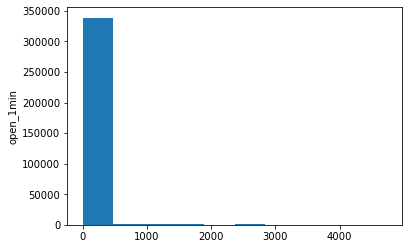

In [26]:
plt.hist(XTRAIN[:,0])
plt.ylabel("open_1min")
plt.show()

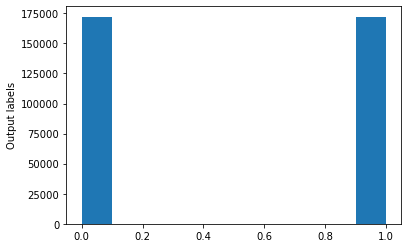

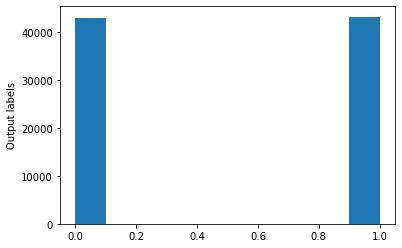

In [27]:
plt.hist(YTRAIN)
plt.ylabel("Output labels")
plt.show()

plt.hist(YVALIDATION)
plt.ylabel("Output labels")
plt.show()

Tenderalization (mean normalization)

In [28]:
mean = XTRAIN.mean(axis=0)
XTRAIN -= mean 
std = XTRAIN.std(axis=0)
XTRAIN /= std

XVALIDATION -=mean
XVALIDATION /= std

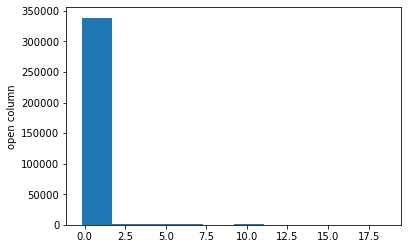

In [30]:
plt.hist(XTRAIN[:,0])
plt.ylabel("open column")
plt.show()

In [31]:
print(XTRAIN.shape)
print(YTRAIN.shape)
print(XVALIDATION.shape)
print(YVALIDATION.shape)

(343952, 758)
(343952,)
(85988, 758)
(85988,)


# Neural network model

### Model Generator

In [32]:
IN_DIM=len(XTRAIN[0,:])

#code genrator
global All_Hist
try:
    with open('Results_history.json') as json_file:
        All_Hist = json.load(json_file)
except:
    All_Hist={0.000001:"code"}

try:
    All_Hist.pop('1e-06')
except:
    print(All_Hist)


In [2]:
mean.shape()

NameError: name 'mean' is not defined

In [ ]:


def auto_code_gen():
    NumLayer=random.randint(1, 5)
    InpLay=int(random.randint(1, max(2,int(NumLayer/random.randint(3,NumLayer+4)+4))))
    act_func=['tanh','relu','sigmoid','softmax','softplus']
    dropout_val=[0.2,0.3,0.4,0.5,0.6,0.7]
    decreaser=1
    IN_DIM=len(XTRAIN[0,:])
    code="model.add(Dense(int(IN_DIM/"+str(InpLay)+"),input_dim=IN_DIM,activation=\'"+random.choice(act_func)+"\'))\n"
    for i in range(0,NumLayer):
        code+='model.add(Dense(int(IN_DIM/'+str(random.randint(1,max(2,(i+1)*2)+1))+'),activation=\''+random.choice(act_func)+'\'))\n'
        if random.choice([True,False]):
            code+='model.add(Dropout('+str(random.choice(dropout_val))+'))\n'
    code+='model.add(Dense(1,activation=\'sigmoid\'))'
    return code

def model_tester(max_tests=500): 
    code=""
    for c in range(1,max_tests+1):
        model = Sequential()
        if code  in All_Hist.values(): break
        code=auto_code_gen()
        exec(code)
        print(model.summary())
        #model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
        model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
        callbacks_a = ModelCheckpoint(filepath ='XcryptoAi_model.hdf5',monitor ='val_accuracy',save_best_only = True, save_weights = True)
        callbacks_b = EarlyStopping(monitor ='val_accuracy',mode='auto',patience=20,verbose=1)
        history = model.fit(XTRAIN,
                        YTRAIN,
                        validation_data=(XVALIDATION,YVALIDATION),
                        epochs=1200,
                        batch_size=5000,
                        callbacks=[callbacks_a,callbacks_b])

        print('##########################################################################')
        print(f"------val_accuracy-----> {'{0:.4g}'.format(max(history.history['val_accuracy'])*100)} | {'{0:.4g}'.format(max(history.history['accuracy'])*100)} <----------accuracy----------")
        All_Hist[max(history.history['val_accuracy'])]=code
        with open('Results_history.json', 'w') as fp:
            json.dump(All_Hist, fp,  indent=4)


model_tester(max_tests=500)

The neural network architecture:
- layer 1 : 764 neurons
- layer 2 : 8 neurons
- layer 3 : neurons 

## Model Test

## Compile the model 

In [ ]:
model = Sequential()
model.add(Dense(int(IN_DIM/2),input_dim=IN_DIM,activation='softplus'))
model.add(Dense(int(IN_DIM/2),activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(int(IN_DIM/5),activation='softplus'))
model.add(Dense(int(IN_DIM/4),activation='softmax'))
model.add(Dense(int(IN_DIM/1),activation='softplus'))
model.add(Dense(1,activation='sigmoid'))
print(model.summary())
#model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
callbacks_a = ModelCheckpoint(filepath ='XcryptoAi_model.hdf5',monitor ='val_accuracy',save_best_only = True, save_weights = True)
callbacks_b = EarlyStopping(monitor ='val_accuracy',mode='auto',patience=20,verbose=1)
history = model.fit(XTRAIN,
                YTRAIN,
                validation_data=(XVALIDATION,YVALIDATION),
                epochs=1200,
                batch_size=5000,
                callbacks=[callbacks_a,callbacks_b])

print('##########################################################################')
print(f"------val_accuracy-----> {'{0:.4g}'.format(max(history.history['val_accuracy'])*100)} | {'{0:.4g}'.format(max(history.history['accuracy'])*100)} <----------accuracy----------")


In [ ]:
accuracy = model.evaluate(XVALIDATION, YVALIDATION)


### Use the model

In [44]:

# make probability predictions with the model
predictions = model.predict(XVALIDATION)
# round predictions 
rounded = [round(x[0]) for x in predictions]

In [50]:
rounded[1002]

0

In [51]:
YVALIDATION[1002]

0.0

In [ ]:
def Buy_Dessision(input):
    predictions = model.predict(XVALIDATION)
    rounded = [round(x[0]) for x in predictions]